In [2]:
import numpy as np 
from cifar10 import *
from mnist import * 
import torch
import matplotlib.pyplot as plt

In [3]:
train_loader, val_loader = get_cifar10_train_valid_loader('data', batch_size=4, augment=False, random_seed=1, valid_size=0.1,
                                                            shuffle=False,)

In [4]:
a, b = train_loader.dataset[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


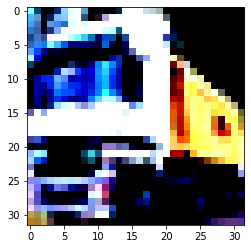

In [5]:
plt.imshow(a.permute(1,2,0))

In [6]:
a = next(iter(val_loader))

In [7]:
a[1]

tensor([9, 5, 8, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


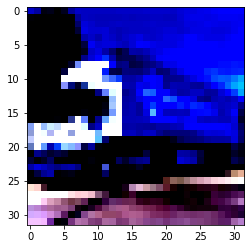

In [8]:
plt.imshow(a[0][0].squeeze().permute(1,2,0))

In [46]:
import scipy.special
logits=np.random.rand(5, 10)
probs = None
labels = np.random.randint(0, 10, 5)

assert (probs is None) != (logits is None)
if probs is None:
    probs = scipy.special.softmax(logits, axis=-1)

nlabels = probs.shape[-1]

flat_probs = probs.reshape([-1, nlabels])
print(flat_probs)

flat_labels = labels.reshape([len(flat_probs)])
print(flat_labels)

plabel = flat_probs[np.arange(len(flat_labels)), flat_labels]
print(plabel)

out = np.square(flat_probs).sum(axis=-1) - 2 * plabel + 1
print(out)

[[0.10380974 0.10215063 0.07955215 0.11832535 0.08406014 0.11955526
  0.08397883 0.0841999  0.14277903 0.08158898]
 [0.08100687 0.1282646  0.07194226 0.1254612  0.11572105 0.11978855
  0.06022852 0.13755416 0.0728198  0.08721299]
 [0.11106305 0.07545965 0.06764344 0.12033106 0.1344622  0.14178943
  0.09207074 0.06194788 0.08644753 0.10878502]
 [0.08204381 0.1108515  0.11875085 0.09972264 0.10425965 0.07569975
  0.09258878 0.07997192 0.13894802 0.09716308]
 [0.0598156  0.12629325 0.13109142 0.06198788 0.14062907 0.0789602
  0.10515437 0.07717077 0.08630251 0.13259494]]
[8 0 8 7 6]
[0.14277903 0.08100687 0.08644753 0.07997192 0.10515437]
[0.81852683 0.94511448 0.93399554 0.94343771 0.89830017]
